In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import umap
import warnings

from dirichlet import mle
from scipy.special import rel_entr
from scipy.stats import dirichlet
from sklearn.manifold import TSNE
from src.models.synthesis.wgan.utils import CustomHistory
from src.models.synthesis.wgan.critics import MLPCritic
from src.models.synthesis.wgan.generators import MLPGenerator
from src.models.synthesis.wgan.wgan import WGANGP, critic_loss, generator_loss


warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

tf.__version__

'2.16.1'

# Dirichlet samples

In [ ]:
train_data_path = os.path.join("data", "processed", "experimental", "synthetic", "train*1*")

for filename in glob.glob(train_data_path):
    df = pd.read_csv(filename)
    compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0
    alpha = mle(compositions)
    break

print(alpha)
compositions

NameError: name 'alpha' is not defined

# Wasserstein GAN samples

In [ ]:
# Training WGAN
latent_dim = 16
lambda_ = 10.0
n_critic = 5
lr = 0.0001
beta_1, beta_2 = 0.5, 0.9
batch_size = 32
epochs = 3000

output_dim = compositions.shape[-1]

print(f"samples, features: {compositions.values.shape}", end="\n\n")
data = compositions.values.astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.batch(batch_size)

critic = MLPCritic(hidden_units=[512, 512, 512])
generator = MLPGenerator(output_dim=output_dim, hidden_units=[512, 512, 512])

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)

# Get the Wasserstein GAN model
wgan = WGANGP(critic=critic, generator=generator, latent_dim=latent_dim, n_critic=n_critic, lambda_=lambda_)

# Compile the Wasserstein GAN model
wgan.compile(
    critic_optimizer=critic_optimizer,
    generator_optimizer=generator_optimizer,
    critic_loss_fn=critic_loss,
    generator_loss_fn=generator_loss,
)

callbacks = [CustomHistory()]
wgan.fit(dataset, epochs=epochs, callbacks=callbacks)

critic.save(os.path.join("notebooks", "models", "critic_model.keras"))
generator.save(os.path.join("notebooks", "models", "generator_model.keras"))

neg_critic_loss = -np.array(callbacks[0].history["critic_loss"])
batches = neg_critic_loss.shape[0]

samples, features: (266, 24)

Epoch 1/3000


2024-10-09 11:13:12.202306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-09 11:13:12.202735: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - critic_loss: 0.9188 - generator_loss: 0.0198
Epoch 2/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - critic_loss: -0.3278 - generator_loss: -0.0224
Epoch 3/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - critic_loss: -0.1814 - generator_loss: -0.1154
Epoch 4/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - critic_loss: -0.1714 - generator_loss: 0.1806
Epoch 5/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - critic_loss: -0.1401 - generator_loss: -0.0535
Epoch 6/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - critic_loss: -0.0633 - generator_loss: -0.0663
Epoch 7/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - critic_loss: -0.0432 - generator_loss: -0.0935
Epoch 8/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - critic_loss: -0.1062 - generator_loss: 0.3170
Epoch 9/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - critic_loss: -0.0512 - generator_loss: 0.0795
Epoch 10/3000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - critic_loss: -0.0623 - generator_loss: 0.0185
Epoch 11/3000
9/9 

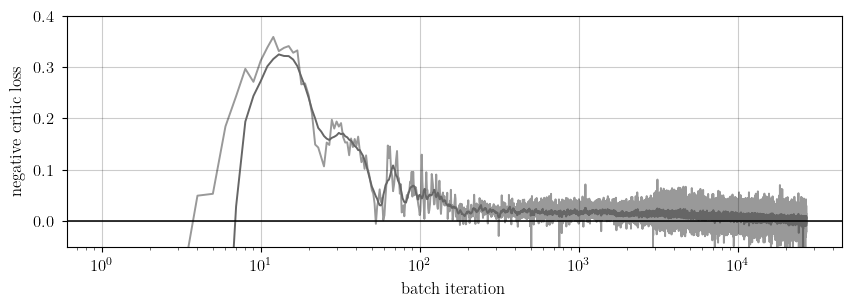

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(batches), neg_critic_loss, alpha=0.4)
ax.plot(np.arange(batches), pd.Series(neg_critic_loss).rolling(10, center=True).median())
ax.set_xlabel("batch iteration")
ax.set_ylabel("negative critic loss")
ax.set_ylim([-0.05, 0.4])
ax.axhline(y=0.0, color=("black", 0.8), linestyle="-")
ax.grid()

# ax.set_yscale('log')
ax.set_xscale("log")
plt.show()

In [ ]:
valid_data_path = os.path.join("data", "processed", "experimental", "synthesis", "valid*1*")

for filename in glob.glob(valid_data_path):
    df = pd.read_csv(filename)
    valid_compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0

generator_model_filename = os.path.join("notebooks", "models", "generator_model.keras")
generator = tf.keras.models.load_model(generator_model_filename)

samples_size = valid_compositions.shape[0]
print(f"Samples size: {samples_size}")

noise = tf.random.normal([samples_size, 16])

dirichlet_comps = dirichlet.rvs(alpha, size=samples_size)
wgan_comps = generator(noise, training=False)

data = np.r_[valid_compositions.values, dirichlet_comps, wgan_comps]

tsne = TSNE(n_components=2, perplexity=100)
tsne_reduced = tsne.fit_transform(data)
tsne_truth, tsne_dirichlet, tsne_wgan = np.split(tsne_reduced, 3, axis=0)

umap_ = umap.UMAP(n_neighbors=50, n_components=2, metric="euclidean", min_dist=0.1)
umap_reduced = umap_.fit_transform(data)
umap_truth, umap_dirichlet, umap_wgan = np.split(umap_reduced, 3, axis=0)

Samples size: 89


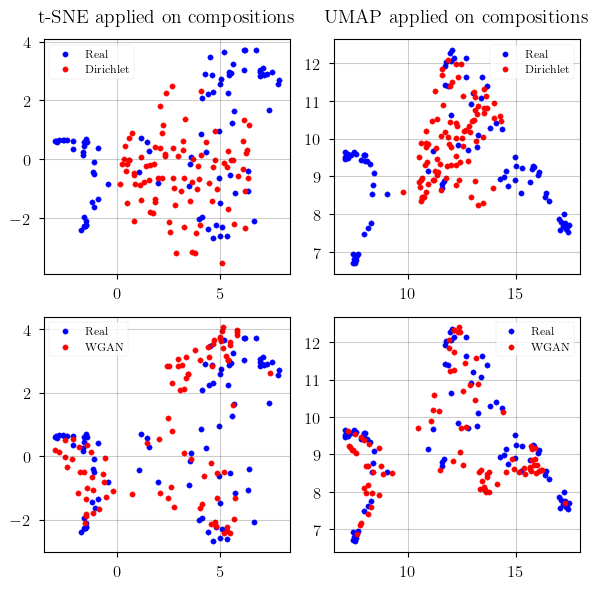

In [ ]:
def dim_reduction_plots(*projections):

    def scatter(samples, ax, model, set_title=False):
        ax.scatter(
            samples["truth"][:, 0],
            samples["truth"][:, 1],
            s=15,
            label="Real",
            c="blue",
        )
        ax.scatter(
            samples[model]["data"][:, 0],
            samples[model]["data"][:, 1],
            s=15,
            label=samples[model]["name"],
            c="red",
        )
        ax.legend(prop={"size": 8})
        if set_title:
            ax.set_title(f"{projection['method']} applied on compositions")
        # ax.set_axis_off()
        ax.grid(alpha=0.2)

    f, axs = plt.subplots(2, 2, figsize=(6, 6))

    for i, projection in enumerate(projections):
        gen_datasets = [p for p in projection["samples"] if p != "truth"]
        for j, model in enumerate(gen_datasets):
            scatter(projection["samples"], axs[j, i], model, set_title=j == 0)

    f.tight_layout()
    # img_filepath = os.path.join("synthetic_data", "dimensionality_reduction_samples.png")
    # f.savefig(img_filepath, dpi=600)


projections = [
    {
        "samples": {
            "truth": tsne_truth,
            "dirichlet": {"data": tsne_dirichlet, "name": "Dirichlet"},
            "wgan": {"data": tsne_wgan, "name": "WGAN"},
        },
        "method": "t-SNE",
    },
    {
        "samples": {
            "truth": umap_truth,
            "dirichlet": {"data": umap_dirichlet, "name": "Dirichlet"},
            "wgan": {"data": umap_wgan, "name": "WGAN"},
        },
        "method": "UMAP",
    },
]
dim_reduction_plots(*projections)

DKL(truth|dirichlet) = 8.4176
DKL(truth|wgan) = 5.4949


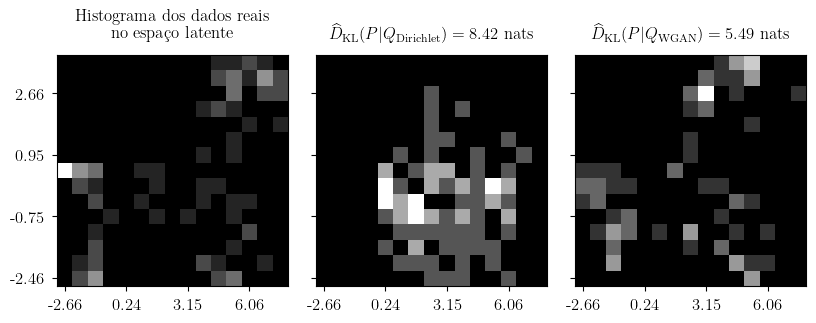

In [ ]:
# 1. t-SNE on data 24dim -> 2dim
# 2. Histogram 2dim
# 3. KL divergence estimation on histogram


def normalized_histogram(data, bins):
    H, xedges, yedges = np.histogram2d(
        data[:, 0],
        data[:, 1],
        bins=bins,
        density=True,
    )
    xdelta = np.asarray([xedges[i + 1] - xedges[i] for i in range(H.shape[0])]).reshape(1, -1)
    ydelta = np.asarray([yedges[i + 1] - yedges[i] for i in range(H.shape[1])]).reshape(-1, 1)
    return H * xdelta * ydelta, xedges, yedges, xdelta, ydelta


def kl_divergence(p: np.ndarray, q: np.ndarray):
    p_mod, q_mod = p.copy(), q.copy()
    q_mod = np.where((q_mod == 0) & (p_mod > 0), 1e-6, q_mod)
    return rel_entr(p_mod, q_mod)


truth_reduced = tsne_truth.copy()
dirichlet_reduced = tsne_dirichlet.copy()
wgan_reduced = tsne_wgan.copy()

# Freedman-Diaconis Estimator
from scipy import stats

xwidth = 2 * stats.iqr(truth_reduced[:, 0]) / truth_reduced[:, 0].shape[0]
ywidth = 2 * stats.iqr(truth_reduced[:, 1]) / truth_reduced[:, 1].shape[0]

# Arbitrary bins counts
bins = 15

H_truth, xedges, yedges, xdelta, ydelta = normalized_histogram(truth_reduced, bins=bins)
H_dirichlet, _, _, _, _ = normalized_histogram(dirichlet_reduced, bins=[xedges, yedges])
H_wgan, _, _, _, _ = normalized_histogram(wgan_reduced, bins=[xedges, yedges])

kl_truth_dirichlet = kl_divergence(H_truth, H_dirichlet).sum()
kl_truth_wgan = kl_divergence(H_truth, H_wgan).sum()
print(f"DKL(truth|dirichlet) = {kl_truth_dirichlet:.4f}")
print(f"DKL(truth|wgan) = {kl_truth_wgan:.4f}")

f, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
axs[0].imshow(H_truth.T, origin="lower")
axs[0].set_title("Histograma dos dados reais\nno espaço latente", fontsize=12)

axs[1].imshow(H_dirichlet.T, origin="lower")
axs[1].set_title(
    r"$\widehat{D}_{\mathrm{KL}}(P|Q_{{\mathrm{Dirichlet}}}) = " + f"{kl_truth_dirichlet:.2f}" + "$ nats",
    fontsize=12,
)

axs[2].imshow(H_wgan.T, origin="lower")
axs[2].set_title(
    r"$\widehat{D}_{\mathrm{KL}}(P|Q_{{\mathrm{WGAN}}}) = " + f"{kl_truth_wgan:.2f}" + "$ nats",
    fontsize=12,
)

for ax in axs:
    ax.set_xticks(
        np.arange(0, xedges.shape[0], 4),
        [f"{tick:.2f}" for tick in (xedges[:-1] + (xdelta / 2).flatten())[::4]],
    )
    ax.set_yticks(
        np.arange(0, yedges.shape[0], 4),
        [f"{tick:.2f}" for tick in (yedges[:-1] + (ydelta / 2).flatten())[::4]],
    )

f.subplots_adjust(wspace=0.01)
plt.savefig(os.path.join("data", "images", "kldiv_estimation_example.png"), dpi=600, bbox_inches="tight")
plt.show()

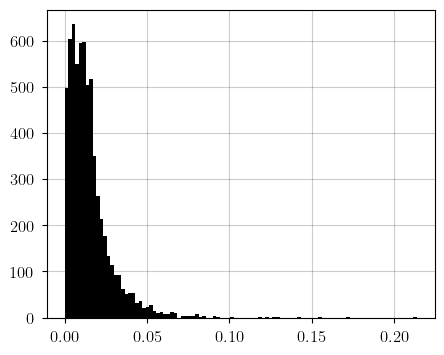

In [ ]:
residual = data - umap_.inverse_transform(umap_reduced)

f, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.abs(residual.flatten()), bins=100)
ax.grid(alpha=0.2)
plt.show()